In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
style.use('seaborn')

from sklearn import linear_model 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

Read in data and format 

In [8]:
def format_data(df, lags):
    
    df.rename(columns = {'Unnamed: 0':'day'}, inplace = True)
    df.drop(columns=['adjClose', 'adjHigh', 'adjLow','adjOpen', 'adjVolume', 
                        'divCash', 'splitFactor'], inplace=True)

    price = df['close']
    price_next_day = df['close'].shift(1)
    df['log_returns'] = np.log(price/price_next_day)
    returns = df['log_returns']

    # buy 1 or sell -1 signals
    df['signal'] = np.sign(df['log_returns'])


    cols = []

    for lag in range(1, lags+1):
        col = 'lag_{}'.format(lag)
        df[col] = returns.shift(lag)
        cols.append(col)

    df.dropna(inplace=True)
    return df, cols

In [13]:
df = pd.read_csv('../data/ETHUSD.csv')
lags = 5
df, cols = format_data(df, lags)
df.head()

,day,date,close,high,low,open,volume,log_returns,signal,lag_1,lag_2,lag_3,lag_4,lag_5
6,6,2021-01-08,1216.751571,1262.290424,1085.546172,1225.661462,1.797646e+06,-0.006405,-1.0,0.012480,0.094158,0.054970,0.062572,0.233714
7,7,2021-01-09,1277.456309,1305.823731,1171.661108,1216.669204,2.093173e+06,0.048686,1.0,-0.006405,0.012480,0.094158,0.054970,0.062572
8,8,2021-01-1,1254.720733,1349.475651,1165.847880,1277.548286,2.928351e+06,-0.017958,-1.0,0.048686,-0.006405,0.012480,0.094158,0.054970
9,9,2021-01-11,1087.469986,1260.199167,912.604580,1254.659819,6.565873e+06,-0.143059,-1.0,-0.017958,0.048686,-0.006405,0.012480,0.094158
10,10,2021-01-12,1050.260409,1150.055396,1006.276283,1087.335624,3.285628e+06,-0.034816,-1.0,-0.143059,-0.017958,0.048686,-0.006405,0.012480


In [14]:
df['signal'].value_counts()

 1.0    175
-1.0    138
Name: signal, dtype: int64

In [32]:
lm_full = linear_model.LogisticRegression(C=1e7, solver='lbfgs') 
lm_full.fit(df[cols], df['signal'])


df['predictions'] = lm_full.predict(df[cols])

df['buy_prob'] = lm_full.predict_proba(df[cols])[:,1]
df['sell_prob'] = lm_full.predict_proba(df[cols])[:,0]
hits = np.sign(df['log_returns'].iloc[lags:] * df['predictions'].iloc[lags:]).value_counts()
hits

 1.0    174
-1.0    134
dtype: int64

In [33]:
df['predictions'].value_counts()

 1.0    251
-1.0     62
Name: predictions, dtype: int64

In [34]:
accuracy_score(df['predictions'], np.sign(df['log_returns']))

0.5654952076677316

In [35]:
df['strategy'] = df['predictions'] * df['log_returns']

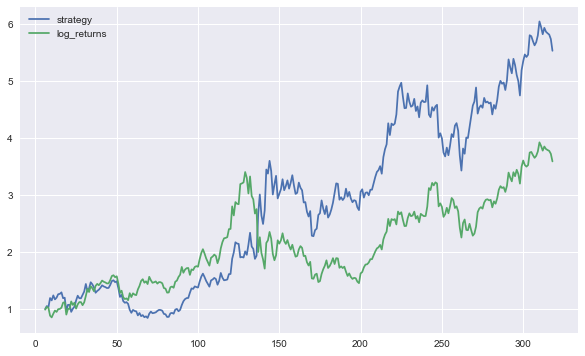

In [68]:
df[['strategy', 'log_returns']].cumsum().apply(np.exp).plot(figsize=(10,6))
# plt.savefig('../graphs/train_returns.png')
plt.show()

Try with test Data

In [37]:
df_test = pd.read_csv('../test_data/ETHUSD.csv')
df_test, cols = format_data(df_test, lags)
df_test.head()

,day,date,close,high,low,open,volume,log_returns,signal,lag_1,lag_2,lag_3,lag_4,lag_5
6,6,2021-11-23,4341.695776,4386.305480,4064.319448,4088.650975,47881.297789,0.060320,1.0,-0.041243,-0.035494,0.026876,0.072178,-0.070362
7,7,2021-11-24,4272.610133,4375.576398,4168.147837,4341.696954,33929.019664,-0.016040,-1.0,0.060320,-0.041243,-0.035494,0.026876,0.072178
8,8,2021-11-25,4525.216946,4551.806504,4247.399482,4270.439785,573224.578712,0.057441,1.0,-0.016040,0.060320,-0.041243,-0.035494,0.026876
9,9,2021-11-26,4040.282001,4552.818755,3917.747777,4525.607985,795001.562496,-0.113351,-1.0,0.057441,-0.016040,0.060320,-0.041243,-0.035494
10,10,2021-11-27,4096.358260,4184.699619,4028.972843,4042.034941,405804.518989,0.013784,1.0,-0.113351,0.057441,-0.016040,0.060320,-0.041243


In [49]:
df_test['predictions'] = lm_full.predict(df_test[cols])
df_test['strategy'] = df['predictions'] * df['log_returns']
df_test.head()

,day,date,close,high,low,open,volume,log_returns,signal,lag_1,lag_2,lag_3,lag_4,lag_5,predictions,buy_prob,sell_prob,strategy
6,6,2021-11-23,4341.695776,4386.305480,4064.319448,4088.650975,47881.297789,0.060320,1.0,-0.041243,-0.035494,0.026876,0.072178,-0.070362,1.0,0.699521,0.300479,0.006405
7,7,2021-11-24,4272.610133,4375.576398,4168.147837,4341.696954,33929.019664,-0.016040,-1.0,0.060320,-0.041243,-0.035494,0.026876,0.072178,1.0,0.508196,0.491804,0.048686
8,8,2021-11-25,4525.216946,4551.806504,4247.399482,4270.439785,573224.578712,0.057441,1.0,-0.016040,0.060320,-0.041243,-0.035494,0.026876,1.0,0.502849,0.497151,-0.017958
9,9,2021-11-26,4040.282001,4552.818755,3917.747777,4525.607985,795001.562496,-0.113351,-1.0,0.057441,-0.016040,0.060320,-0.041243,-0.035494,1.0,0.540821,0.459179,0.143059
10,10,2021-11-27,4096.358260,4184.699619,4028.972843,4042.034941,405804.518989,0.013784,1.0,-0.113351,0.057441,-0.016040,0.060320,-0.041243,1.0,0.676386,0.323614,-0.034816


In [50]:
df_test['predictions'].value_counts()

 1.0    14
-1.0     2
Name: predictions, dtype: int64

In [51]:
accuracy_score(df_test['predictions'], np.sign(df_test['log_returns']))

0.5625

In [52]:
predicted_prob = lm_full.predict_proba(df_test[cols])
df_test['buy_prob'] = predicted_prob[:,1]
df_test['sell_prob'] = predicted_prob[:,0]
df_test.head()

,day,date,close,high,low,open,volume,log_returns,signal,lag_1,lag_2,lag_3,lag_4,lag_5,predictions,buy_prob,sell_prob,strategy
6,6,2021-11-23,4341.695776,4386.305480,4064.319448,4088.650975,47881.297789,0.060320,1.0,-0.041243,-0.035494,0.026876,0.072178,-0.070362,1.0,0.699521,0.300479,0.006405
7,7,2021-11-24,4272.610133,4375.576398,4168.147837,4341.696954,33929.019664,-0.016040,-1.0,0.060320,-0.041243,-0.035494,0.026876,0.072178,1.0,0.508196,0.491804,0.048686
8,8,2021-11-25,4525.216946,4551.806504,4247.399482,4270.439785,573224.578712,0.057441,1.0,-0.016040,0.060320,-0.041243,-0.035494,0.026876,1.0,0.502849,0.497151,-0.017958
9,9,2021-11-26,4040.282001,4552.818755,3917.747777,4525.607985,795001.562496,-0.113351,-1.0,0.057441,-0.016040,0.060320,-0.041243,-0.035494,1.0,0.540821,0.459179,0.143059
10,10,2021-11-27,4096.358260,4184.699619,4028.972843,4042.034941,405804.518989,0.013784,1.0,-0.113351,0.057441,-0.016040,0.060320,-0.041243,1.0,0.676386,0.323614,-0.034816


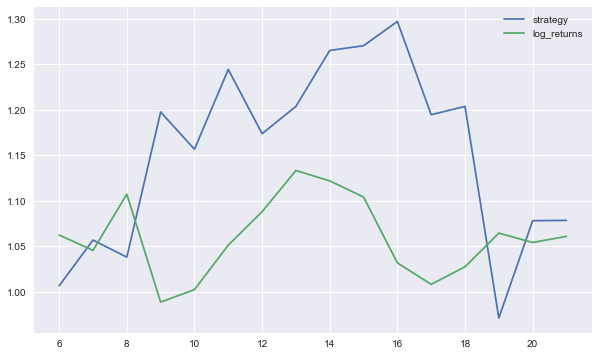

In [84]:
df_test[['strategy', 'log_returns']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.savefig('../graphs/test_returns')
plt.show()

Plot ROC Curve

In [75]:

def plot_roc(df):
    fpr, tpr, thresholds = roc_curve(df['predictions'], np.sign(df['log_returns']))
    auc = roc_auc_score(df['predictions'], np.sign(df['log_returns']))
    print('fpr: {}'.format(fpr))
    print('tpr: {}'.format(tpr))
    print('thresholds: {}'.format(thresholds))
    print('auc: {}'.format(auc))
    plt.plot(fpr,tpr,label="signal data, auc="+str(auc))
#     plt.savefig('../graphs/train_roc.png')
#     plt.savefig('../graphs/test_roc.png')
    plt.show()

fpr: [0.         0.48387097 1.        ]
tpr: [0.         0.57768924 1.        ]
thresholds: [ 2.  1. -1.]
auc: 0.5469091376429764


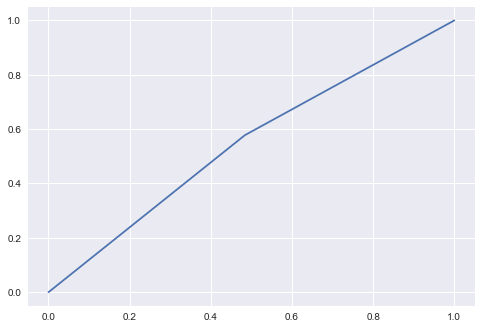

In [72]:
plot_roc(df)

fpr: [0.  0.5 1. ]
tpr: [0.         0.57142857 1.        ]
thresholds: [ 2.  1. -1.]
auc: 0.5357142857142857


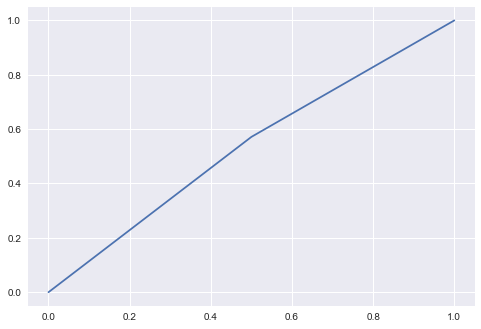

In [74]:
plot_roc(df_test)

Plot probabilities

In [58]:
df.head()

,day,date,close,high,low,open,volume,log_returns,signal,lag_1,lag_2,lag_3,lag_4,lag_5,predictions,strategy,buy_prob,sell_prob
6,6,2021-01-08,1216.751571,1262.290424,1085.546172,1225.661462,1.797646e+06,-0.006405,-1.0,0.012480,0.094158,0.054970,0.062572,0.233714,-1.0,0.006405,0.397256,0.602744
7,7,2021-01-09,1277.456309,1305.823731,1171.661108,1216.669204,2.093173e+06,0.048686,1.0,-0.006405,0.012480,0.094158,0.054970,0.062572,1.0,0.048686,0.562211,0.437789
8,8,2021-01-1,1254.720733,1349.475651,1165.847880,1277.548286,2.928351e+06,-0.017958,-1.0,0.048686,-0.006405,0.012480,0.094158,0.054970,1.0,-0.017958,0.575851,0.424149
9,9,2021-01-11,1087.469986,1260.199167,912.604580,1254.659819,6.565873e+06,-0.143059,-1.0,-0.017958,0.048686,-0.006405,0.012480,0.094158,-1.0,0.143059,0.492359,0.507641
10,10,2021-01-12,1050.260409,1150.055396,1006.276283,1087.335624,3.285628e+06,-0.034816,-1.0,-0.143059,-0.017958,0.048686,-0.006405,0.012480,1.0,-0.034816,0.619209,0.380791


In [79]:
def plot_probs(df):
    plt.title('ETHUSD Predicted Probabilities')
#     plt.scatter(df['day'], df['predictions'], label='Predicted Signals', color='green')
#     plt.scatter(df['day'], df['signal'], label='True Signals', color='blue')
    # plt.plot(test_date, test_close)
    plt.plot(df['day'],df['buy_prob'], 'g-', label='Buy Prob')
    plt.plot(df['day'],df['sell_prob'], 'r--', label='Sell Prob')
    plt.legend()
#     plt.savefig('../graphs/train_probs.png')
    plt.savefig('../graphs/test_probs.png')
    plt.show()

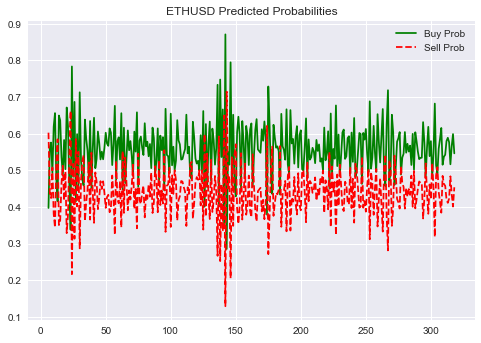

In [78]:
# for training
plot_probs(df)

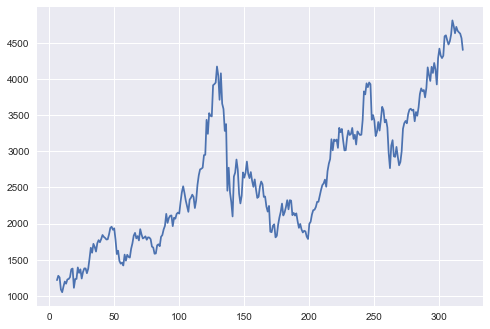

In [83]:
df['close'].plot()
plt.savefig('../graphs/train_close.png')

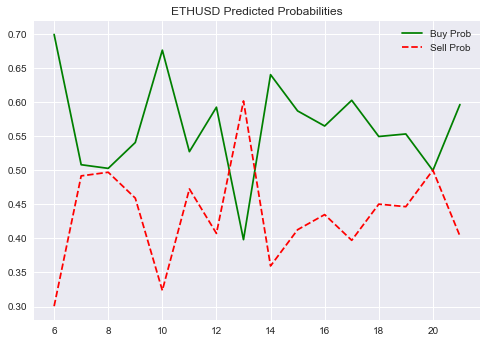

In [81]:
# for testing
plot_probs(df_test)

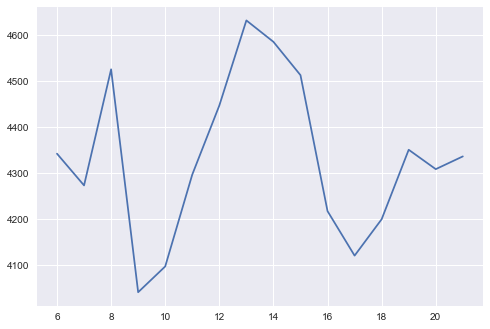

In [82]:
df_test['close'].plot()
plt.savefig('../graphs/test_close.png')